<a href="https://colab.research.google.com/github/PsorTheDoctor/artificial-intelligence/blob/master/modern_approach/text_to_image/cross_attention_control/latent_diffusion_prompt_to_prompt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Prompt-to-Prompt with Latent Diffusion

In [ ]:
%pip install -q --upgrade diffusers==0.3.0 transformers

In [ ]:
!git clone https://github.com/google/prompt-to-prompt.git
%cd prompt-to-prompt/

In [3]:
from typing import Optional, Union, Tuple, List, Callable, Dict
import torch
from diffusers import DiffusionPipeline, StableDiffusionPipeline
import torch.nn.functional as nnf
import numpy as np
import abc
import ptp_utils
import seq_aligner
from PIL import Image

In [ ]:
LOW_RESOURCE = False 
NUM_DIFFUSION_STEPS = 50
GUIDANCE_SCALE = 7.5
MAX_NUM_WORDS = 77
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
ldm = DiffusionPipeline.from_pretrained('CompVis/ldm-text2im-large-256').to(device)
tokenizer = ldm.tokenizer

##Prompt-to-prompt attention controllers

In [10]:
class LocalBlend:
    def __call__(self, x_t, attention_store, step):
        k = 1
        maps = attention_store["down_cross"][:2] + attention_store["up_cross"][3:6]
        maps = [item.reshape(self.alpha_layers.shape[0], -1, 1, 16, 16, MAX_NUM_WORDS) for item in maps]
        maps = torch.cat(maps, dim=1)
        maps = (maps * self.alpha_layers).sum(-1).mean(1)
        mask = nnf.max_pool2d(maps, (k * 2 + 1, k * 2 +1), (1, 1), padding=(k, k))
        mask = nnf.interpolate(maps, size=(x_t.shape[2:]))
        mask = mask / mask.max(2, keepdims=True)[0].max(3, keepdims=True)[0]
        mask = mask.gt(self.threshold)
        mask = (mask[:1] + mask).float()
        x_t = x_t[:1] + mask * (x_t - x_t[:1])
        return x_t
       
    def __init__(self, prompts: List[str], words: [List[List[str]]], threshold: float = .3):
        alpha_layers = torch.zeros(len(prompts),  1, 1, 1, 1, MAX_NUM_WORDS)
        for i, (prompt, words_) in enumerate(zip(prompts, words)):
            if type(words_) is str:
                words_ = [words_]
            for word in words_:
                ind = ptp_utils.get_word_inds(prompt, word, tokenizer)
                alpha_layers[i, :, :, :, :, ind] = 1
        self.alpha_layers = alpha_layers.to(device)
        self.threshold = threshold

class AttentionControl(abc.ABC):
    def step_callback(self, x_t):
        return x_t
    
    def between_steps(self):
        return
    
    @abc.abstractmethod
    def forward (self, attn, is_cross: bool, place_in_unet: str):
        raise NotImplementedError

    def __call__(self, attn, is_cross: bool, place_in_unet: str):
        h = attn.shape[0]
        attn[h // 2:] = self.forward(attn[h // 2:], is_cross, place_in_unet)
        self.cur_att_layer += 1
        if self.cur_att_layer == self.num_att_layers:
            self.cur_att_layer = 0
            self.cur_step += 1
            self.between_steps()
        return attn
    
    def reset(self):
        self.cur_step = 0
        self.cur_att_layer = 0

    def __init__(self):
        self.cur_step = 0
        self.num_att_layers = -1
        self.cur_att_layer = 0

class EmptyControl(AttentionControl):
    def forward (self, attn, is_cross: bool, place_in_unet: str):
        return attn  
    
class AttentionStore(AttentionControl):
    @staticmethod
    def get_empty_store():
        return {"down_cross": [], "mid_cross": [], "up_cross": [],
                "down_self": [],  "mid_self": [],  "up_self": []}

    def forward(self, attn, is_cross: bool, place_in_unet: str):
        if attn.shape[1] <= 16 ** 2:  # avoid memory overhead
            key = f"{place_in_unet}_{'cross' if is_cross else 'self'}"
            self.step_store[key].append(attn)
        return attn

    def between_steps(self):
        if len(self.attention_store) == 0:
            self.attention_store = self.step_store
        else:
            for key in self.attention_store:
                for i in range(len(self.attention_store[key])):
                    self.attention_store[key][i] += self.step_store[key][i]
        self.step_store = self.get_empty_store()

    def get_average_attention(self):
        average_attention = {key: [item / self.cur_step for item in self.attention_store[key]] for key in self.attention_store}
        return average_attention
        
    def reset(self):
        super(AttentionStore, self).reset()
        self.step_store = self.get_empty_store()
        self.attention_store = {}

    def __init__(self):
        super(AttentionStore, self).__init__()
        self.step_store = self.get_empty_store()
        self.attention_store = {}
      
class AttentionControlEdit(AttentionStore, abc.ABC):
    def step_callback(self, x_t):
        if self.local_blend is not None:
            x_t = self.local_blend(x_t, self.attention_store, self.cur_step)
        return x_t
        
    def replace_self_attention(self, attn_base, att_replace):
        if att_replace.shape[2] <= 16 ** 2:
            return attn_base.unsqueeze(0).expand(att_replace.shape[0], *attn_base.shape)
        else:
            return att_replace
    
    @abc.abstractmethod
    def replace_cross_attention(self, attn_base, att_replace):
        raise NotImplementedError
    
    def forward(self, attn, is_cross: bool, place_in_unet: str):
        super(AttentionControlEdit, self).forward(attn, is_cross, place_in_unet)
        if is_cross or (self.num_self_replace[0] <= self.cur_step < self.num_self_replace[1]):
            h = attn.shape[0] // (self.batch_size)
            attn = attn.reshape(self.batch_size, h, *attn.shape[1:])
            attn_base, attn_repalce = attn[0], attn[1:]
            if is_cross:
                alpha_words = self.cross_replace_alpha[self.cur_step]
                attn_repalce_new = self.replace_cross_attention(attn_base, attn_repalce) * alpha_words + (1 - alpha_words) * attn_repalce
                attn[1:] = attn_repalce_new
            else:
                attn[1:] = self.replace_self_attention(attn_base, attn_repalce)
            attn = attn.reshape(self.batch_size * h, *attn.shape[2:])
        return attn
    
    def __init__(self, prompts, num_steps: int,
                 cross_replace_steps: Union[float, Tuple[float, float], Dict[str, Tuple[float, float]]],
                 self_replace_steps: Union[float, Tuple[float, float]],
                 local_blend: Optional[LocalBlend]):
        super(AttentionControlEdit, self).__init__()
        self.batch_size = len(prompts)
        self.cross_replace_alpha = ptp_utils.get_time_words_attention_alpha(
            prompts, num_steps, cross_replace_steps, tokenizer
        ).to(device)
        if type(self_replace_steps) is float:
            self_replace_steps = 0, self_replace_steps
        self.num_self_replace = int(num_steps * self_replace_steps[0]), int(num_steps * self_replace_steps[1])
        self.local_blend = local_blend

class AttentionReplace(AttentionControlEdit):
    def replace_cross_attention(self, attn_base, att_replace):
        return torch.einsum('hpw,bwn->bhpn', attn_base, self.mapper)
      
    def __init__(self, prompts, num_steps: int, cross_replace_steps: float, self_replace_steps: float,
                 local_blend: Optional[LocalBlend] = None):
        super(AttentionReplace, self).__init__(prompts, num_steps, cross_replace_steps, 
                                               self_replace_steps, local_blend)
        self.mapper = seq_aligner.get_replacement_mapper(prompts, tokenizer).to(device)       

class AttentionRefine(AttentionControlEdit):
    def replace_cross_attention(self, attn_base, att_replace):
        attn_base_replace = attn_base[:, :, self.mapper].permute(2, 0, 1, 3)
        attn_replace = attn_base_replace * self.alphas + att_replace * (1 - self.alphas)
        return attn_replace

    def __init__(self, prompts, num_steps: int, cross_replace_steps: float, self_replace_steps: float,
                 local_blend: Optional[LocalBlend] = None):
        super(AttentionRefine, self).__init__(prompts, num_steps, cross_replace_steps, 
                                              self_replace_steps, local_blend)
        self.mapper, alphas = seq_aligner.get_refinement_mapper(prompts, tokenizer)
        self.mapper, alphas = self.mapper.to(device), alphas.to(device)
        self.alphas = alphas.reshape(alphas.shape[0], 1, 1, alphas.shape[1])

class AttentionReweight(AttentionControlEdit):
    def replace_cross_attention(self, attn_base, att_replace):
        if self.prev_controller is not None:
            attn_base = self.prev_controller.replace_cross_attention(attn_base, att_replace)
        attn_replace = attn_base[None, :, :, :] * self.equalizer[:, None, None, :]
        return attn_replace

    def __init__(self, prompts, num_steps: int, cross_replace_steps: float, self_replace_steps: float, equalizer,
                local_blend: Optional[LocalBlend] = None, controller: Optional[AttentionControlEdit] = None):
        super(AttentionReweight, self).__init__(prompts, num_steps, cross_replace_steps, 
                                                self_replace_steps, local_blend)
        self.equalizer = equalizer.to(device)
        self.prev_controller = controller

def get_equalizer(text: str, word_select: Union[int, Tuple[int, ...]], values: Union[List[float],
                  Tuple[float, ...]]):
    if type(word_select) is int or type(word_select) is str:
        word_select = (word_select,)
    equalizer = torch.ones(len(values), 77)
    values = torch.tensor(values, dtype=torch.float32)
    for word in word_select:
        inds = ptp_utils.get_word_inds(text, word, tokenizer)
        for i in inds:
            equalizer[:, i] = values
    return equalizer

def aggregate_attention(attention_store: AttentionStore, res: int, 
                        from_where: List[str], is_cross: bool, select: int):
    out = []
    attention_maps = attention_store.get_average_attention()
    num_pixels = res ** 2
    for location in from_where:
        for item in attention_maps[f"{location}_{'cross' if is_cross else 'self'}"]:
            if item.shape[1] == num_pixels:
                cross_maps = item.reshape(len(prompts), -1, res, res, item.shape[-1])[select]
                out.append(cross_maps)
    out = torch.cat(out, dim=0)
    out = out.sum(0) / out.shape[0]
    return out.cpu()

def show_cross_attention(attention_store: AttentionStore, res: int, 
                         from_where: List[str], select: int = 0):
    tokens = tokenizer.encode(prompts[select])
    decoder = tokenizer.decode
    attention_maps = aggregate_attention(attention_store, res, from_where, True, select)
    images = []
    for i in range(len(tokens)):
        image = attention_maps[:, :, i]
        image = 255 * image / image.max()
        image = image.unsqueeze(-1).expand(*image.shape, 3)
        image = image.numpy().astype(np.uint8)
        image = np.array(Image.fromarray(image).resize((256, 256)))
        image = ptp_utils.text_under_image(image, decoder(int(tokens[i])))
        images.append(image)
    ptp_utils.view_images(np.stack(images, axis=0))

def show_self_attention_comp(attention_store: AttentionStore, res: int, 
                             from_where: List[str], max_com=10, select: int = 0):
    attention_maps = aggregate_attention(
        attention_store, res, from_where, False, select
    ).numpy().reshape((res ** 2, res ** 2))
    u, s, vh = np.linalg.svd(attention_maps - np.mean(attention_maps, axis=1, keepdims=True))
    images = []
    for i in range(max_com):
        image = vh[i].reshape(res, res)
        image = image - image.min()
        image = 255 * image / image.max()
        image = np.repeat(np.expand_dims(image, axis=2), 3, axis=2).astype(np.uint8)
        image = Image.fromarray(image).resize((256, 256))
        image = np.array(image)
        images.append(image)
    ptp_utils.view_images(np.concatenate(images, axis=1))

def sort_by_eq(eq):
    def inner_(images):
        swap = 0
        if eq[-1] < 1:
            for i in range(len(eq)):
                if eq[i] > 1 and eq[i + 1] < 1:
                    swap = i + 2
                    break
        else:
             for i in range(len(eq)):
                if eq[i] < 1 and eq[i + 1] > 1:
                    swap = i + 2
                    break
        print(swap)
        if swap > 0:
            images = np.concatenate([images[1:swap], images[:1], images[swap:]], axis=0)
            
        return images
    return inner_

def run_and_display(prompts, controller, latent=None, run_baseline=True, 
                    callback:Optional[Callable[[np.ndarray], np.ndarray]] = None, generator=None):
    if run_baseline:
        print("w.o. prompt-to-prompt")
        images, latent = run_and_display(prompts, EmptyControl(), latent=latent, run_baseline=False)
        print("results with prompt-to-prompt")
    images, x_t = ptp_utils.text2image_ldm(
        ldm, prompts, controller, latent=latent, num_inference_steps=NUM_DIFFUSION_STEPS, 
        guidance_scale=GUIDANCE_SCALE, generator=generator)
    if callback is not None:
        images = callback(images)
    ptp_utils.view_images(images)
    return images, x_t

##Cross attention visualization

  0%|          | 0/50 [00:00<?, ?it/s]

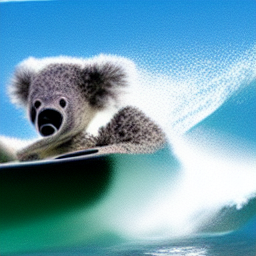

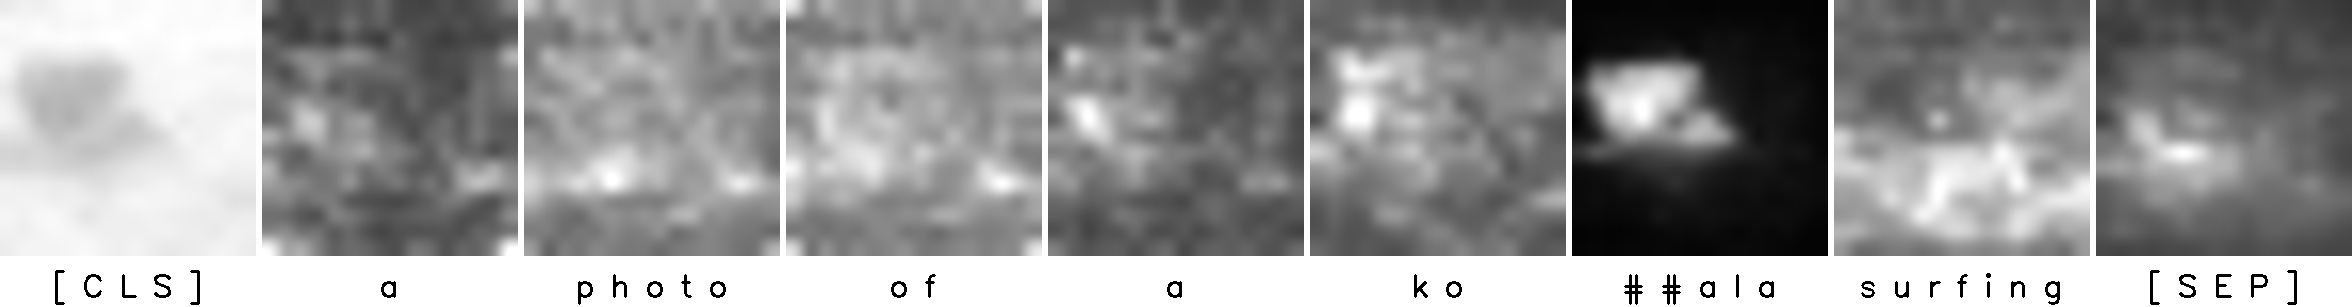

In [17]:
g_cpu = torch.Generator().manual_seed(888)
prompts = ['a photo of a koala surfing']
controller = AttentionStore()
images, x_t = run_and_display(prompts, controller, run_baseline=False, generator=g_cpu)
show_cross_attention(controller, res=16, from_where=['up', 'down'])

##Replacement edit

w.o. prompt-to-prompt


  0%|          | 0/50 [00:00<?, ?it/s]

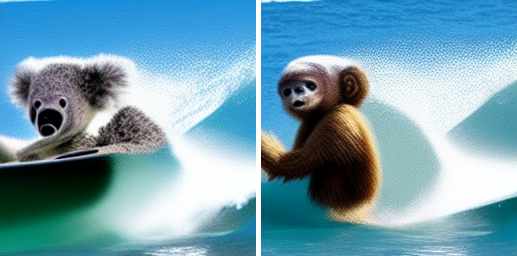

results with prompt-to-prompt


  0%|          | 0/50 [00:00<?, ?it/s]

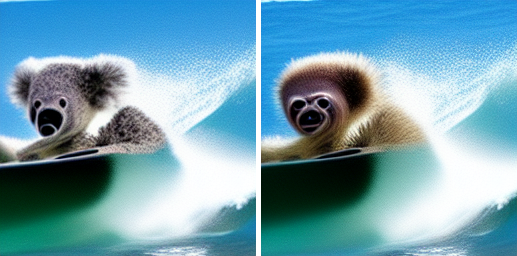

In [19]:
prompts = ['a photo of a koala surfing', 'a photo of a sloth surfing']

controller = AttentionReplace(prompts, NUM_DIFFUSION_STEPS, cross_replace_steps=.8, self_replace_steps=.2)
_ = run_and_display(prompts, controller, latent=x_t, run_baseline=True)

  0%|          | 0/50 [00:00<?, ?it/s]

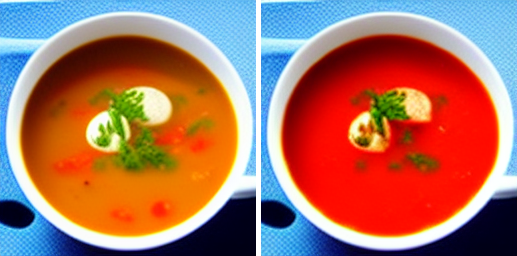

In [24]:
prompts = ['soup', 'tomato soup']
lb = LocalBlend(prompts, ('soup', 'soup'))

controller = AttentionRefine(prompts, NUM_DIFFUSION_STEPS, cross_replace_steps=.8,
                             self_replace_steps=.2,
                             local_blend=lb)
_ = run_and_display(prompts, controller, latent=x_t, run_baseline=False)

##Attention re-weighting

  0%|          | 0/50 [00:00<?, ?it/s]

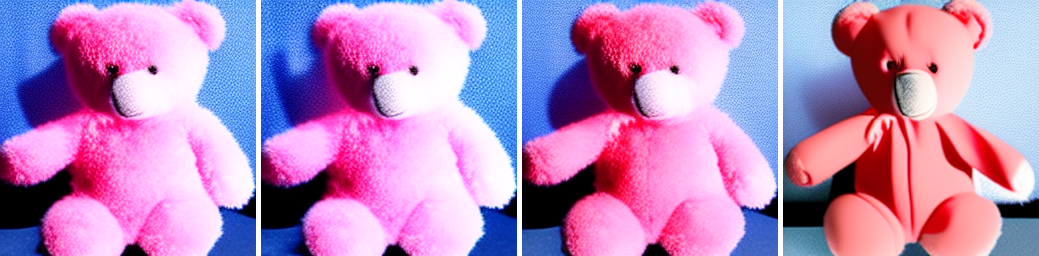

In [30]:
prompts = ['a fluffy teddy bear'] * 4

equalizer = get_equalizer(prompts[1], word_select=('fluffy',), values=(2, 0, -2))
controller = AttentionReweight(prompts, NUM_DIFFUSION_STEPS, cross_replace_steps=.8,
                               self_replace_steps=.2,
                               equalizer=equalizer)
_ = run_and_display(prompts, controller, latent=x_t, run_baseline=False)